# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [7]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, min, max, countDistinct, count
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import Normalizer, StandardScaler, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt

In [8]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Capstone Project") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [9]:
sparkify_data = 'mini_sparkify_event_data.json'
df = spark.read.json(sparkify_data)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [10]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [11]:
# Print information for each column
for column in df.columns:
    df.describe([column]).show()

+-------+------------------+
|summary|            artist|
+-------+------------------+
|  count|            228108|
|   mean| 551.0852017937219|
| stddev|1217.7693079161374|
|    min|               !!!|
|    max| ÃÂlafur Arnalds|
+-------+------------------+

+-------+----------+
|summary|      auth|
+-------+----------+
|  count|    286500|
|   mean|      null|
| stddev|      null|
|    min| Cancelled|
|    max|Logged Out|
+-------+----------+

+-------+---------+
|summary|firstName|
+-------+---------+
|  count|   278154|
|   mean|     null|
| stddev|     null|
|    min| Adelaida|
|    max|   Zyonna|
+-------+---------+

+-------+------+
|summary|gender|
+-------+------+
|  count|278154|
|   mean|  null|
| stddev|  null|
|    min|     F|
|    max|     M|
+-------+------+

+-------+------------------+
|summary|     itemInSession|
+-------+------------------+
|  count|            286500|
|   mean|114.41421291448516|
| stddev|129.76726201140994|
|    min|                 0|
|    max| 

In [12]:
# Print null values for each column
for column in df.columns:
    print(column, "with null values: ", df.filter(df[column].isNull()).count())

artist with null values:  58392
auth with null values:  0
firstName with null values:  8346
gender with null values:  8346
itemInSession with null values:  0
lastName with null values:  8346
length with null values:  58392
level with null values:  0
location with null values:  8346
method with null values:  0
page with null values:  0
registration with null values:  8346
sessionId with null values:  0
song with null values:  58392
status with null values:  0
ts with null values:  0
userAgent with null values:  8346
userId with null values:  0


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [13]:
# Add a column for the "churn" indicator
df = df.withColumn("Churn", df["page"] == "Cancellation Confirmation")

In [14]:
# Check whether the average number of "itemInSession" differs for churn==true and false
df.groupBy("Churn").avg("itemInSession").show()

+-----+------------------+
|Churn|avg(itemInSession)|
+-----+------------------+
| true|  88.1923076923077|
|false| 114.4189730771379|
+-----+------------------+



In [15]:
# Check whether the number of users differs for churn==true and false
df.groupBy("Churn").agg(countDistinct("UserId")).show()

+-----+----------------------+
|Churn|count(DISTINCT UserId)|
+-----+----------------------+
| true|                    52|
|false|                   226|
+-----+----------------------+



In [16]:
# Check whether the number of rows differs for churn==true and false
df.groupBy("Churn").count().show()

+-----+------+
|Churn| count|
+-----+------+
| true|    52|
|false|286448|
+-----+------+



In [17]:
# Check the correlation between churn and the gender
df.groupBy("Churn", "Gender").count().show()

+-----+------+------+
|Churn|Gender| count|
+-----+------+------+
| true|     F|    20|
|false|     M|123544|
| true|     M|    32|
|false|     F|154558|
|false|  null|  8346|
+-----+------+------+



In [18]:
# Check all values of the "page" column
df.select("page").distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
+--------------------+
only showing top 20 rows



# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

## Feature to be engineered

I want to use the following features in my model:  
1) thumbs down and up per UserId  
2) songs played  
3) duration used (max_ts - min_ts per UserId)  
4) songs played
5) errors per hour or day  
6) add to playlist per day

In [19]:
# Print different values of column "page"
df.select("page").distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
+--------------------+
only showing top 20 rows



In [20]:
# Calculate the number of downvotes per user id
thumbs_down = df.filter(df["page"] == "Thumbs Down").groupby("UserId").agg(count("Page").alias("Number of Thumbs Down"))

Text(0.5,1,'Distribution of Downvotes')

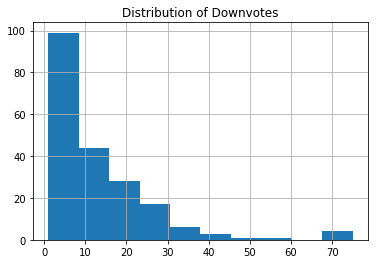

In [21]:
df_vis1 = thumbs_down.toPandas()
df_vis1.hist("Number of Thumbs Down")
plt.title("Distribution of Downvotes")

In [22]:
# Calculate the number of upvotes per user id
thumbs_up = df.filter(df["page"] == "Thumbs Up").groupby("UserId").agg(count("Page").alias("Number of Thumbs Up"))

Text(0.5,1,'Distribution of Upvotes')

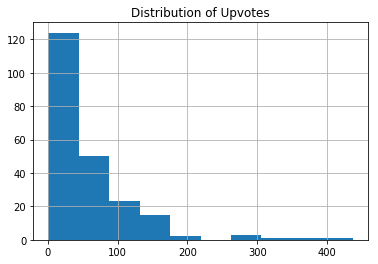

In [23]:
df_vis2 = thumbs_up.toPandas()
df_vis2.hist("Number of Thumbs Up")
plt.title("Distribution of Upvotes")

In [24]:
# Calculate the number of songs per user id
songs = df.filter(df["Song"].isNotNull()).groupby("UserId").agg(count("Page").alias("Number of Songs"))

Text(0.5,1,'Number of Songs played per User')

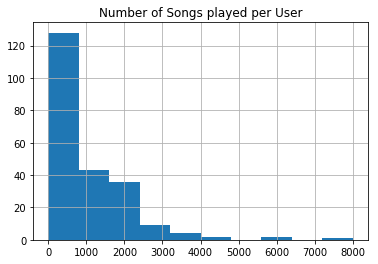

In [25]:
df_vis3 = songs.toPandas()
df_vis3.hist("Number of Songs")
plt.title("Number of Songs played per User")

In [26]:
# Calculate the usage time of a user id by using the time span between min ts and max ts
timespan = df.groupby("UserId").agg(((max(("ts"))-min(("ts")))/(3600*1000)).cast(IntegerType()).alias("Duration in Hours"))
timespan = timespan.withColumn("Duration in Days", col("Duration in Hours")/24)

Text(0.5,1,'Distribution of Timespan in Days')

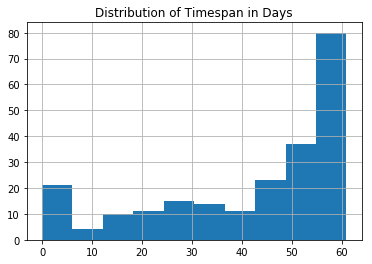

In [27]:
df_vis4 = timespan.toPandas()
df_vis4.hist("Duration in Days")
plt.title("Distribution of Timespan in Days")

In [28]:
# Calculate the number of songs added to a playlist per user id
playlist = df.filter(df["page"] == "Add to Playlist").groupby("UserId").agg(count("Page").alias("Added to Playlist"))

Text(0.5,1,'Distribution of Songs added to Playlist')

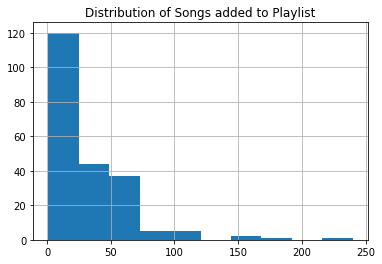

In [29]:
df_vis5 = playlist.toPandas()
df_vis5.hist("Added to Playlist")
plt.title("Distribution of Songs added to Playlist")

In [30]:
# Calculate the number of error pages seen per user id
error = df.filter(df["status"] == "404").groupby("UserId").agg(count("Page").alias("Number of Errors"))

Text(0.5,1,'Distribution of Number of Errors per User')

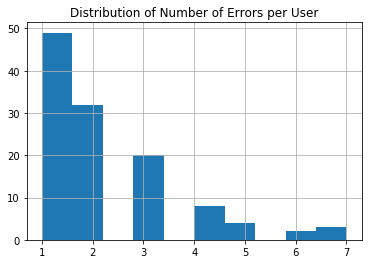

In [31]:
df_vis6 = error.toPandas()
df_vis6.hist("Number of Errors")
plt.title("Distribution of Number of Errors per User")

In [32]:
# Add the column "Churn" based on the "page" column value
churn = df.withColumn("churn", df["page"] == "Cancellation Confirmation")
churn = churn.select(col("churn").cast("integer"), "UserId").distinct()

In [33]:
# Count the number of distinct user ids
churn.count()

278

In [34]:
# join all data
feature_df = thumbs_down\
    .join(thumbs_up, on='userId')\
    .join(timespan, on='userId')\
    .join(playlist, on='userId')\
    .join(error, on='userId')\
    .join(songs, on='userId')\
    .join(churn, on='userId')

In [35]:
# Relativize the absolute numbers according to a period of time
feature_df = feature_df.withColumn("Errors per Day", col("Number of Errors")/col("Duration in Days"))
feature_df = feature_df.drop("Number of Errors")
feature_df = feature_df.withColumn("Playlist Add per Day", col("Added to Playlist")/col("Duration in Days"))
feature_df = feature_df.drop("Added to Playlist")
feature_df = feature_df.drop("UserId")

Text(0.5,1,'Playlist Adds per Day')

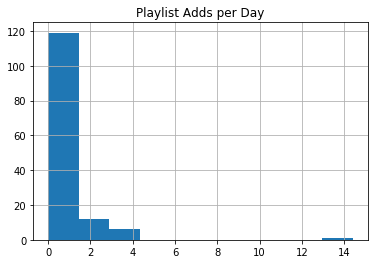

In [38]:
df_vis7 = feature_df.toPandas()
df_vis7.hist("Playlist Add per Day")
plt.title("Playlist Adds per Day")

Text(0.5,1,'Errors per Day')

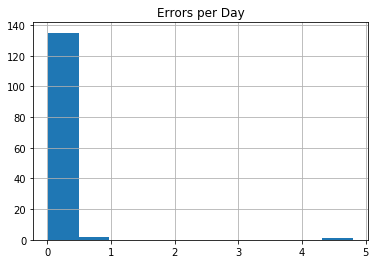

In [39]:
df_vis8 = feature_df.toPandas()
df_vis8.hist("Errors per Day")
plt.title("Errors per Day")

In [40]:
feature_df.printSchema()

root
 |-- Number of Thumbs Down: long (nullable = false)
 |-- Number of Thumbs Up: long (nullable = false)
 |-- Duration in Hours: integer (nullable = true)
 |-- Duration in Days: double (nullable = true)
 |-- Number of Songs: long (nullable = false)
 |-- churn: integer (nullable = true)
 |-- Errors per Day: double (nullable = true)
 |-- Playlist Add per Day: double (nullable = true)



In [41]:
# Calculate the number of null values per columns
for column in feature_df.columns:
    print(column, "with null values: ", feature_df.filter(feature_df[column].isNull()).count())

Number of Thumbs Down with null values:  0
Number of Thumbs Up with null values:  0
Duration in Hours with null values:  0
Duration in Days with null values:  0
Number of Songs with null values:  0
churn with null values:  0
Errors per Day with null values:  0
Playlist Add per Day with null values:  0


Since no columns have any null values anymore, we can proceed without any further data manipulation.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

For this project, I will user three different classification algorithms:  
1) Logistic Regression  
2) Random Forest Classifier  
3) Gradient-Boosted Tree Classifier

### Prepare the data and the models

In [42]:
inputCols = [
 'Number of Thumbs Down',
 'Number of Thumbs Up',
 'Duration in Hours',
 'Duration in Days',
 'Playlist Add per Day',
 'Errors per Day'
]

assembler = VectorAssembler(inputCols=inputCols, outputCol="output_features")
indexer = StringIndexer(inputCol="churn", outputCol="label")
norm = Normalizer(inputCol="output_features", outputCol="features")
#df = assembler.transform(feature_df)
#df = norm.transform(df)
#df = df.select("features", col("churn").alias("label"))

In [43]:
# Split data in train and test data
train, test = feature_df.randomSplit([0.7, 0.3], seed=42)

In [44]:
# Pipeline for the linear regression model
lr = LogisticRegression()
pipeline_lr = Pipeline(stages=[indexer, assembler, norm, lr])

# Pipeline for the random forest model
rf = RandomForestClassifier()
pipeline_rf = Pipeline(stages=[indexer, assembler, norm, rf])

# Pipeline for the gradient boosted tree model
gbt = GBTClassifier()
pipeline_gbt = Pipeline(stages=[indexer, assembler, norm, gbt])

### Linear Regression

In [45]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.3])\
    .addGrid(lr.maxIter, [10])\
    .build()

evaluator = MulticlassClassificationEvaluator(metricName="f1")

crossval = CrossValidator(estimator=pipeline_lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

cv_lr = crossval.fit(train) 
evaluator.evaluate(cv_lr.transform(test))

0.7575757575757576

### Random Forest

In [46]:
paramGrid = ParamGridBuilder() \
    .build()

evaluator = MulticlassClassificationEvaluator(metricName="f1")

crossval = CrossValidator(estimator=pipeline_rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

cv_rf = crossval.fit(train) 
evaluator.evaluate(cv_rf.transform(test))

0.7077625570776254

### Gradient Boosted Tree

In [47]:
paramGrid = ParamGridBuilder() \
    .build()

evaluator = MulticlassClassificationEvaluator(metricName="f1")

crossval = CrossValidator(estimator=pipeline_gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

cv_gbt = crossval.fit(train) 
evaluator.evaluate(cv_gbt.transform(test))

0.6807511737089202

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.